# Evaluate potential of model updating (through retraining)

In [1]:
import os
import sys
import gensim
import numpy as np
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import data

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

In [4]:
# apply post processing steps to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

## Convert to documents

In [5]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]

## Train different models

In [6]:
doc_idx = np.arange(len(documents))
np.random.seed(100)
selected_idx = np.random.choice(doc_idx, 7000, replace=False)  # Pick idx in random order
print(selected_idx[:25])

[12160  1573  7181 10280  6058 11307 10583  5617  7356 11039  5815  2553
 11644  2334  2138 10261  7681  2092  6493 12642  5776  9390   682  3612
  9463]


In [7]:
import time
from custom_functions.plotting_functions import plot_precentile
from spec2vec.model_building import train_new_word2vec_model

In [9]:
nums_to_remove = [100, 200, 400, 800, 1500, 3000, 6000]
path_models = os.path.join(path_data, "trained_models")
iterations = [30, 50]

collect_times = []
for num_remove in nums_to_remove:
    print(20 * "--")
    print(f"Remove {num_remove} of {len(documents)} spectra.")
    file_model = os.path.join(path_models, f"spec2vec_UniqueInchikeys_{num_remove}_removed_201209.model")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UniqueInchikeys_{num_remove}_removed_201209.npy")
    if num_remove > 100:
        # Train model with default parameters
        tstart_model = time.time()
        model = train_new_word2vec_model([documents[i] for i in doc_idx if i not in selected_idx[:num_remove]],
                                          iterations, file_model)
        t_model = time.time() - tstart_model
    print(f"Model training (20 epochs, {len(documents) - num_remove} spectra): {t_model:.2f} s")
    
    # Score calculation
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=50.0)
    tstart_sim = time.time()
    similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
    t_sim = time.time() - tstart_sim                           
    
    collect_times.append((num_remove, t_model, t_sim))
    print(f"Similarity calculation time: {t_sim:.2f} s")
    np.save(file_matrix, similarity_matrix)

----------------------------------------
Remove 100 of 12797 spectra.
Model training (20 epochs, 12697 spectra): 3285.02 s
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 16 word(s) mi

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 13 word(s) missing in the mode

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.78%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.59%.
Similarity calculation time: 53.22 s
----------------------------------------
Remove 400 of 12797 spectra.
  Epoch 1 of 50.Change in loss after epoch 1: 1686266.25
  Epoch 2 of 50.Change in loss after epoch 2: 1301033.5
  Epoch 3 of 50.Change in loss after epoch 3: 1184961.75
  Epoch 4 of 50.Change in loss after epoch 4: 1071612.5
  Epoch 5 of 50.Change 

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 2 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.05%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.93%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 5 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.78%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.67%.
Found 5 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.93%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 1 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.40%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.17%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.59%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.02%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.85%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 1 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 5 word(s) missing in the model.

  Epoch 16 of 50.Change in loss after epoch 16: 651558.0
  Epoch 17 of 50.Change in loss after epoch 17: 612633.0
  Epoch 18 of 50.Change in loss after epoch 18: 620073.0
  Epoch 19 of 50.Change in loss after epoch 19: 597416.0
  Epoch 20 of 50.Change in loss after epoch 20: 574631.0
  Epoch 21 of 50.Change in loss after epoch 21: 506028.0
  Epoch 22 of 50.Change in loss after epoch 22: 415806.0
  Epoch 23 of 50.Change in loss after epoch 23: 402660.0
  Epoch 24 of 50.Change in loss after epoch 24: 386326.0
  Epoch 25 of 50.Change in loss after epoch 25: 380980.0
  Epoch 26 of 50.Change in loss after epoch 26: 370538.0
  Epoch 27 of 50.Change in loss after epoch 27: 359426.0
  Epoch 28 of 50.Change in loss after epoch 28: 343346.0
  Epoch 29 of 50.Change in loss after epoch 29: 328266.0
  Epoch 30 of 50.Change in loss after epoch 30: 316734.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.59%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 19 word(s) missing in the 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.09%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 4 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.55%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.
Found 1 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.32%.
Found 3 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.38%.
Found 1 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.09%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.43%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 2 word(s) missing in the model.

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.60%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.56%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 2 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.67%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.92%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.26%.
Similarity calculation time: 51.16 s
----------------------------------------
Remove 3000 of 12797 spectra.
  Epoch 1 of 50.Change in loss after epoch 1: 1349986.375
  Epoch 2 of 50.Change in loss after epoch 2: 1019705.125
  Epoch 3 of 50.Change 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.17%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.92%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model.

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.42%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 1 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.38%.
Found 2 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.86%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 2 word(s) missing in the model

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.88%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.41%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 2 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.72%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the mode

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.54%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.18%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.88%.
Found 7 word(s) missing in the mode

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.27%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.26%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.81%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.89%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.64%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.51%.
Found 41 word(s) missing in the m

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.10%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.97%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.25%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.61%.
Found 2 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 14 word(s) missing in the model

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.42%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 1 word(s) missing in the model

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 2 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.86%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 4 word(s) missing in the model

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.88%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.41%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 17 word(s) missing in the mode

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.72%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 4 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 1 word(s) missing in the mode

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 1 word(s) missing in the model.

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.18%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.91%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 3 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.53%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.96%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.62%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 3 word(s) missing in the model.

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.80%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.03%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.68%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.37%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.32%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.18%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.19%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.81%.
Found 41 word(s) missing in the m

  Epoch 10 of 50.Change in loss after epoch 10: 527013.0
  Epoch 11 of 50.Change in loss after epoch 11: 520674.5
  Epoch 12 of 50.Change in loss after epoch 12: 506855.0
  Epoch 13 of 50.Change in loss after epoch 13: 477892.0
  Epoch 14 of 50.Change in loss after epoch 14: 464757.5
  Epoch 15 of 50.Change in loss after epoch 15: 432725.0
  Epoch 16 of 50.Change in loss after epoch 16: 411200.0
  Epoch 17 of 50.Change in loss after epoch 17: 392328.0
  Epoch 18 of 50.Change in loss after epoch 18: 406228.0
  Epoch 19 of 50.Change in loss after epoch 19: 382557.0
  Epoch 20 of 50.Change in loss after epoch 20: 381957.0
  Epoch 21 of 50.Change in loss after epoch 21: 363562.0
  Epoch 22 of 50.Change in loss after epoch 22: 353273.0
  Epoch 23 of 50.Change in loss after epoch 23: 337057.0
  Epoch 24 of 50.Change in loss after epoch 24: 335328.0
  Epoch 25 of 50.Change in loss after epoch 25: 329401.0
  Epoch 26 of 50.Change in loss after epoch 26: 313707.0
  Epoch 27 of 50.Change in loss

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.63%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.13%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.20%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.66%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.60%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.82%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.54%.
Found 42 word(s) missing i

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.65%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 2 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.17%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.67%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.95%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 12 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.72%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.80%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.31%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.73%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.30%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 10 word(s) missing in the 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.51%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.85%.
Found 19 word(s) missing in the mod

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.37%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 3 word(s) missing in the model

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.83%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.42%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model.

Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.63%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.67%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.13%.
Found 1 word(s) missing in the model

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.47%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 2 word(s) missing in the model

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.95%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 4 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.61%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.
Found 1 word(s) missing in the mode

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.12%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 5 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.70%.
Found 5 word(s) missing in the mod

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.91%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.09%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the mode

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.56%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 6 word(s) missing in the mode

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 1 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.42%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.38%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model.

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.71%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.81%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 13 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 7 word(s) missing in the model

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.34%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.80%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.55%.
Found 2 word(s) missing in the mode

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.96%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.98%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.10%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.08%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.78%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.71%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.57%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.03%.
Found 1 word(s) missing in t

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.52%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.07%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.09%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.23%.
Found 3 word(s) missing in the mo

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.04%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the mode

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 12 word(s) missing in the mode

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.10%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.95%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in th

Found 158 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.77%.


AssertionError: ('Missing percentage is larger than set maximum.', 'Consider retraining the used model or increasing the allowed percentage.')

In [10]:
# Score calculation
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=80.0)
tstart_sim = time.time()
similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
t_sim = time.time() - tstart_sim                           

collect_times.append((num_remove, t_model, t_sim))
print(f"Similarity calculation time: {t_sim:.2f} s")
np.save(file_matrix, similarity_matrix)

Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.86%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.84%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.99%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.48%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.73%.
Found 8 word(s) missing in th

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 163 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.34%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.69%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.73%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.91%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 5 word(s) missing i

Found 179 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.51%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.67%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.94%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.13%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 2 word(s) missing in the 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.97%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.91%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.93%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.16%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.62%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.03%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.29%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 14 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.37%.
Found 4 word(s) missing in the model.

Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.88%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.98%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.77%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.83%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.45%.
Found 5 word(s) missing in the mode

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.83%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.42%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.58%.
Found 1 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.42%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.63%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 7 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.54%.
Found 5 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 4 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.53%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.59%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 1 word(s) missing in the model

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.28%.
Found 3 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.11%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 2 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.95%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 1 word(s) missing in the model.

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.98%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.43%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.
Found 2 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.91%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.74%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.65%.
Found 10 word(s) missing in the mod

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.78%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 1 word(s) missing in the mod

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.71%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.47%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 2 word(s) missing in the model

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.26%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.67%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.23%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.84%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.88%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.02%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.90%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.73%.
Found 5 word(s) missing in the mod

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.74%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.65%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.77%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.48%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.73%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.73%.
Found 1 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.84%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 26 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.10%.
Found 2 word(s) missing in the mode

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.97%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 5 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.99%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.48%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.73%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 1 word(s) missing in the m

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 3 word(s) missing in the mode

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.15%.
Found 179 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.51%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.67%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.94%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.13%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 1 word(s) missing in the

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.67%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.95%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 5 word(s) missing in the mo

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.80%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.31%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.73%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.30%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 5 word(s) missing in the 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.51%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.85%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 4 word(s) missing in the mod

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.37%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.78%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 43 word(s) missing in the m

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.42%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 12 word(s) missing in the model

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 2 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.90%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 2 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.67%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 2 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.47%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 7 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.54%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.05%.
Found 1 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.05%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.47%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.54%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 7 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 1 word(s) missing in the model

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.29%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.70%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 2 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.80%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 5 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 1 word(s) missing in the model.

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.05%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.89%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.98%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 1 word(s) missing in the mode

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 5 word(s) missing in the model.

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 1 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.58%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.33%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.46%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.77%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.24%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.28%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.78%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 1 word(s) missing in the mod

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.97%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.20%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.58%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.91%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.
Found 3 word(s) missing in the mo

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.12%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.61%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.22%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.97%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.98%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.89%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.71%.
Found 7 word(s) missing in the

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 9 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.74%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.29%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.68%.
Found 6 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.63%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.92%.
Found 1 word(s) missing in the m

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 8 word(s) missing in the model.

In [16]:
file_matrix

'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\similarities_spec2vec_UniqueInchikeys_6000_removed_201209.npy'

In [11]:
filename = os.path.join(path_data,'similarities_daylight2048_jaccard.npy')
matrix_similarities_fingerprint_daylight = np.load(filename)

----------------------------------------
Compute percentiles (0 of 12797 spectra removed).
----------------------------------------
Compute percentiles (100 of 12797 spectra removed).
----------------------------------------
Compute percentiles (200 of 12797 spectra removed).
----------------------------------------
Compute percentiles (400 of 12797 spectra removed).
----------------------------------------
Compute percentiles (800 of 12797 spectra removed).
----------------------------------------
Compute percentiles (1500 of 12797 spectra removed).
----------------------------------------
Compute percentiles (3000 of 12797 spectra removed).
----------------------------------------
Compute percentiles (6000 of 12797 spectra removed).


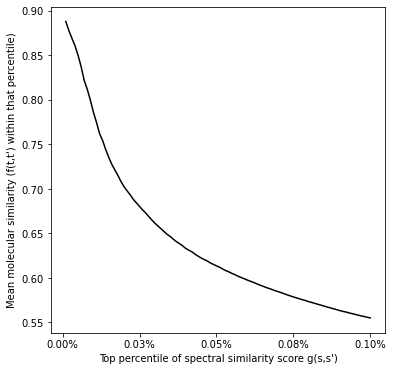

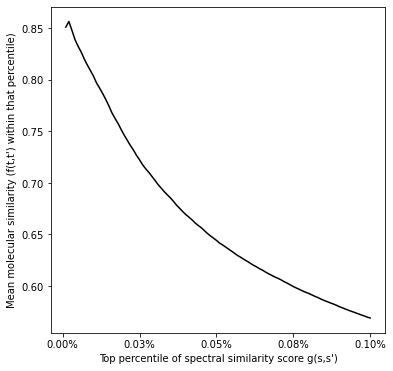

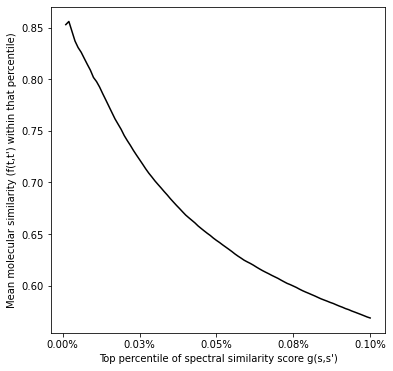

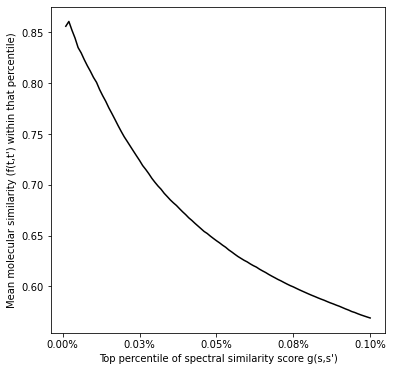

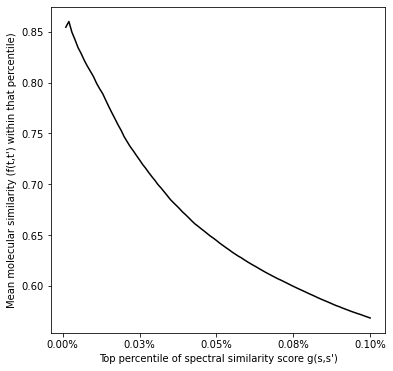

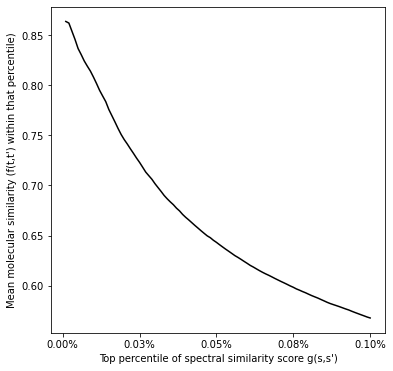

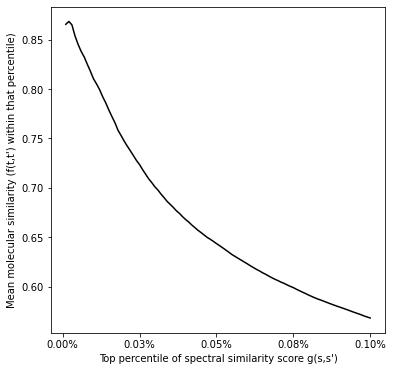

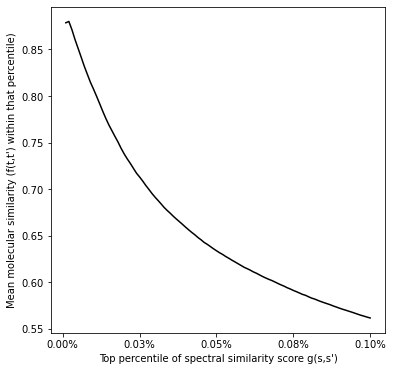

In [13]:
nums_to_remove = [0, 100, 200, 400, 800, 1500, 3000, 6000]
percentiles = []

for num_remove in nums_to_remove:
    print(20 * "--")
    print(f"Compute percentiles ({num_remove} of {len(documents)} spectra removed).")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UniqueInchikeys_{num_remove}_removed_201209.npy")
    matrix_similarities_spec2vec = np.load(file_matrix)
    percentile = plot_precentile(matrix_similarities_fingerprint_daylight,
                               matrix_similarities_spec2vec,
                               num_bins=100, show_top_percentile=0.1,
                               ignore_diagonal=True)
    percentiles.append(percentile)

(0.4, 0.92)

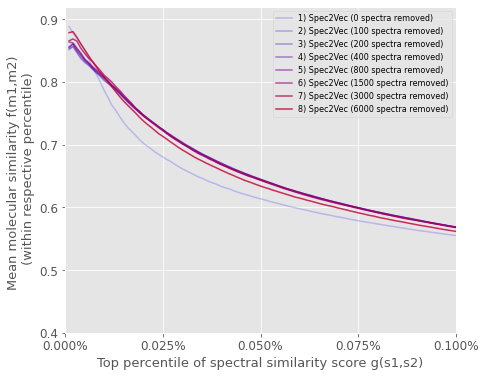

In [15]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles):
    plt.plot(x_percentiles, percentiles[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_remove[i]} spectra removed)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

### comment on above figure: 0 spectra removed case was run for 20 instead of 50 iterations!

In [17]:
len(model.wv.vocab)

97132

# Run experiment on subset of UniqueInchikey

In [31]:
doc_idx = np.arange(len(documents))

selected_idx = np.arange(len(documents))
np.random.seed(100)
np.random.shuffle(selected_idx)  # Pick idx in random order
print(selected_idx[:25])

[12160  1573  7181 10280  6058 11307 10583  5617  7356 11039  5815  2553
 11644  2334  2138 10261  7681  2092  6493 12642  5776  9390   682  3612
  9463]


In [45]:
n_subset = 2000  # --> UI2000 set

documents2000 = [documents[i] for i in selected_idx[:n_subset]]
len(documents2000)

2000

In [39]:
matrix_similarities_fingerprint_daylight[np.ix_(selected_idx[:6], selected_idx[:5])]

array([[       nan, 0.23809524, 0.25802879, 0.17533432, 0.28559738],
       [0.23809524,        nan, 0.26629423, 0.12699468, 0.44230769],
       [0.25802879, 0.26629423,        nan, 0.23554913, 0.35910224],
       [0.17533432, 0.12699468, 0.23554913,        nan, 0.18675253],
       [0.28559738, 0.44230769, 0.35910224, 0.18675253,        nan],
       [0.16693679, 0.100271  , 0.12320917, 0.1373057 , 0.10416667]])

In [43]:
matrix_similarities_fingerprint_daylight[12160, 7181]

0.25802879291251385

In [46]:
nums_to_keep = [500, 1000, 1500]
path_models = os.path.join(path_data, "trained_models")
iterations = [25, 50]

collect_times = []
for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Keep {num_keep} of {len(documents)} spectra.")
    file_model = os.path.join(path_models, f"spec2vec_UI2000_{num_keep}kept_201210.model")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI2000_{num_keep}kept_201210.npy")
    # Train model with default parameters
    tstart_model = time.time()
    model = train_new_word2vec_model([documents[i] for i in selected_idx[:num_keep]],
                                      iterations, file_model)
    t_model = time.time() - tstart_model
    print(f"Model training (20 epochs, {num_keep} spectra): {t_model:.2f} s")
    print(f"Model contains {len(model.wv.vocab)} words in the vocabulary.")
    
    # Score calculation
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0)
    tstart_sim = time.time()
    similarity_matrix = spec2vec_similarity.matrix(documents2000, documents2000, is_symmetric=True)
    t_sim = time.time() - tstart_sim                           
    
    collect_times.append((num_keep, t_model, t_sim))
    print(f"Similarity calculation time: {t_sim:.2f} s")
    np.save(file_matrix, similarity_matrix)

----------------------------------------
Keep 500 of 12797 spectra.
  Epoch 1 of 50.Change in loss after epoch 1: 125555.890625
  Epoch 2 of 50.Change in loss after epoch 2: 117031.25
  Epoch 3 of 50.Change in loss after epoch 3: 93304.546875
  Epoch 4 of 50.Change in loss after epoch 4: 86573.875
  Epoch 5 of 50.Change in loss after epoch 5: 82773.09375
  Epoch 6 of 50.Change in loss after epoch 6: 80986.96875
  Epoch 7 of 50.Change in loss after epoch 7: 79187.375
  Epoch 8 of 50.Change in loss after epoch 8: 76892.6875
  Epoch 9 of 50.Change in loss after epoch 9: 74233.3125
  Epoch 10 of 50.Change in loss after epoch 10: 72025.0
  Epoch 11 of 50.Change in loss after epoch 11: 70794.25
  Epoch 12 of 50.Change in loss after epoch 12: 68159.0
  Epoch 13 of 50.Change in loss after epoch 13: 66268.375
  Epoch 14 of 50.Change in loss after epoch 14: 64840.0
  Epoch 15 of 50.Change in loss after epoch 15: 63318.875
  Epoch 16 of 50.Change in loss after epoch 16: 61944.375
  Epoch 17 of 50

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.65%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.49%.
Found 156 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.40%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.41%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.93%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.81%.
Found 81 word(s) missing

Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.72%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.94%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.07%.
Found 403 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.32%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.83%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.95%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.13%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.91%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.12%.
Found 81 word(s) missi

Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.62%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.82%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.14%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.54%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.08%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.68%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.60%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.26%.
Found 55 word(s) missin

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.78%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.13%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.27%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 53.77%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.22%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.19%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.68%.
Found 56 word(s) missin

Found 186 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.06%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.91%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.13%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.08%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.99%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.66%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.40%.
Found 7 word(s) miss

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.92%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.74%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.14%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.82%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.76%.
Found 72 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.30%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.43%.
Found 60 word(s) missing

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.09%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.95%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.29%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.13%.
Found 110 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.98%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.79%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.81%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.01%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.12%.
Found 49 word(s) mis

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.72%.
Found 72 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.46%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.02%.
Found 417 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.66%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.48%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.94%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.50%.
Found 137 word(s) missi

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.53%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.58%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.44%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.43%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 83.77%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.80%.
Found 96 word(s) missing 

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.26%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.37%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.32%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.70%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.00%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.42%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.43%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.70%.
Found 105 word(s) missing in the model. Weighted missing percentage not covered by the given model is 62.10%.
Found 35 word(s) missi

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.13%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.78%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.15%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.11%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.62%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 51.65%.
Found 2 word(s) missing in t

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.74%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.23%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.64%.
Found 128 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.54%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.83%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.35%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.55%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.42%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.40%.
Found 3 word(s) missi

Found 253 word(s) missing in the model. Weighted missing percentage not covered by the given model is 55.91%.
Found 90 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.41%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.41%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.75%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.90%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 81.04%.
Found 81 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.21%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.35%.
Found 172 word(s) miss

Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.74%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.05%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.11%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.91%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.99%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.11%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.01%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.95%.
Found 38 word(s) missing

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.49%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.62%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.92%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.25%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.32%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.44%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 83.13%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.16%.
Found 33 word(s) missi

Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.93%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.86%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.68%.
Found 105 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.98%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.61%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.21%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.15%.
Found 16 word(s) missing i

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.09%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.93%.
Found 153 word(s) missing in the model. Weighted missing percentage not covered by the given model is 55.09%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.38%.
Found 65 word(s) missing 

Found 105 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.78%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.90%.
Found 106 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.30%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.08%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.96%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.94%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.19%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.38%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.14%.
Found 57 word(s) mis

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.13%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.08%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.99%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.66%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.40%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.84%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 57.09%.
Found 22 word(s) missi

Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.39%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.89%.
Found 129 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.04%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.63%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.75%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.96%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.66%.
Found 102 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.49%.
Found 123 word(s) missin

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.66%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.34%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 64.21%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.21%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.19%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 5 word(s) missing in 

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.68%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.31%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.74%.
Found 106 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.45%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.75%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.81%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 3 word(s) missing in 

Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.25%.
Found 216 word(s) missing in the model. Weighted missing percentage not covered by the given model is 67.11%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.85%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.96%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.44%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.85%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.57%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.26%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.37%.
Found 88 word(s) mi

Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.63%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.01%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 90 word(s) missing in the model. Weighted missing percentage not covered by the given model is 84.95%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.51%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.08%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.88%.
Found 33 word(s) missing in t

Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.58%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.31%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.97%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.82%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.09%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.11%.
Found 166 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.59%.
Found 78 word(s) missin

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.06%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.75%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.80%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.82%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.71%.
Found 146 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.34%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.60%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.78%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.06%.
Found 67 word(s) miss

Similarity calculation time: 12.25 s
----------------------------------------
Keep 1000 of 12797 spectra.
  Epoch 1 of 50.Change in loss after epoch 1: 207049.71875
  Epoch 2 of 50.Change in loss after epoch 2: 160215.9375
  Epoch 3 of 50.Change in loss after epoch 3: 141235.9375
  Epoch 4 of 50.Change in loss after epoch 4: 134764.65625
  Epoch 5 of 50.Change in loss after epoch 5: 128343.375
  Epoch 6 of 50.Change in loss after epoch 6: 123311.0625
  Epoch 7 of 50.Change in loss after epoch 7: 117775.0
  Epoch 8 of 50.Change in loss after epoch 8: 113198.8125
  Epoch 9 of 50.Change in loss after epoch 9: 110280.5
  Epoch 10 of 50.Change in loss after epoch 10: 106644.875
  Epoch 11 of 50.Change in loss after epoch 11: 103680.25
  Epoch 12 of 50.Change in loss after epoch 12: 102127.75
  Epoch 13 of 50.Change in loss after epoch 13: 100275.5
  Epoch 14 of 50.Change in loss after epoch 14: 97724.375
  Epoch 15 of 50.Change in loss after epoch 15: 94670.0
  Epoch 16 of 50.Change in loss

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.97%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.26%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.93%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.35%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.89%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.78%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.09%.
Found 27 word(s) missing in 

Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.42%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.55%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.69%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.27%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.15%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.53%.
Found 6 word(s) missing 

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.61%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.79%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.44%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.39%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.03%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.13%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.81%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.68%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 4 word(s) missing in th

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.06%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 196 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.88%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.51%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.27%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.42%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.16%.
Found 5 word(s) missing 

Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.69%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.25%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 191 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.66%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.74%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 14 word(s) missing i

Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.53%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.83%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.10%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 255 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.94%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.33%.
Found 1 word(s) missing i

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.11%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.28%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 90 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.68%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.67%.
Found 30 word(s) missing in t

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.11%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.20%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.44%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.38%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.95%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.22%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.88%.
Found 67 word(s) missing 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.15%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.96%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.92%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.03%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.50%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 12 word(s) missing in th

Found 180 word(s) missing in the model. Weighted missing percentage not covered by the given model is 57.90%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.08%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.09%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.33%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.02%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.13%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.29%.
Found 54 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.36%.
Found 11 word(s) missing

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.58%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.05%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.42%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.28%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.43%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.47%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 35 word(s) missing in th

Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.78%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.86%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.77%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.41%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.62%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.95%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.36%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.81%.
Found 220 word(s) missing i

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 255 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.94%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.16%.
Found 86 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.04%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.27%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.28%.
Found 2 word(s) missing i

Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.77%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.62%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.68%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.26%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.17%.
Found 5 word(s) missing i

Found 123 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.58%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.46%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.34%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.33%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.45%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.86%.
Found 6 word(s) missing i

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 142 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.56%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.35%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.05%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.56%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.45%.
Found 54 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.16%.
Found 1 word(s) missing i

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.33%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.16%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.67%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.61%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.15%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.80%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 3 word(s) missing in th

Found 179 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.37%.
Found 98 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.06%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.04%.
Found 96 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.43%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 16 word(s) missing in t

Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.04%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.46%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.26%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.13%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.69%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.63%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.53%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 6 word(s) missing i

Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.95%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.00%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.83%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.80%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.43%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.88%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.80%.
Found 36 word(s) missing in the

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.32%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.90%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.59%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.82%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.25%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.26%.
Found 1 word(s) missing in the

In [61]:
num_keep = 2500
n_subset = 5000

print(20 * "--")
print(f"Keep {num_keep} of {len(documents)} spectra.")
file_model = os.path.join(path_models, f"spec2vec_UI2000_{num_keep}kept_201210.model")
file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI5000_{num_keep}kept_201210.npy")
# Train model with default parameters
tstart_model = time.time()
model = train_new_word2vec_model([documents[i] for i in selected_idx[:num_keep]],
                                  iterations, file_model)
t_model = time.time() - tstart_model
print(f"Model training (20 epochs, {num_keep} spectra): {t_model:.2f} s")
print(f"Model contains {len(model.wv.vocab)} words in the vocabulary.")

# Score calculation
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0)
tstart_sim = time.time()
similarity_matrix = spec2vec_similarity.matrix([documents[i] for i in selected_idx[:n_subset]],
                                               [documents[i] for i in selected_idx[:n_subset]],
                                               is_symmetric=True)
t_sim = time.time() - tstart_sim                           

collect_times.append((num_keep, t_model, t_sim))
print(f"Similarity calculation time: {t_sim:.2f} s")
np.save(file_matrix, similarity_matrix)

----------------------------------------
Keep 2500 of 12797 spectra.
  Epoch 1 of 50.Change in loss after epoch 1: 467506.0
  Epoch 2 of 50.Change in loss after epoch 2: 353920.4375
  Epoch 3 of 50.Change in loss after epoch 3: 322322.4375
  Epoch 4 of 50.Change in loss after epoch 4: 300822.125
  Epoch 5 of 50.Change in loss after epoch 5: 287822.125
  Epoch 6 of 50.Change in loss after epoch 6: 277755.375
  Epoch 7 of 50.Change in loss after epoch 7: 264462.75
  Epoch 8 of 50.Change in loss after epoch 8: 252933.75
  Epoch 9 of 50.Change in loss after epoch 9: 246700.0
  Epoch 10 of 50.Change in loss after epoch 10: 239872.25
  Epoch 11 of 50.Change in loss after epoch 11: 226299.75
  Epoch 12 of 50.Change in loss after epoch 12: 228766.75
  Epoch 13 of 50.Change in loss after epoch 13: 212476.5
  Epoch 14 of 50.Change in loss after epoch 14: 218160.75
  Epoch 15 of 50.Change in loss after epoch 15: 213173.25
  Epoch 16 of 50.Change in loss after epoch 16: 199563.75
  Epoch 17 of 50.

Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.23%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.52%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.96%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.09%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.79%.
Found 5 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.09%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.60%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.77%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.91%.
Found 6 word(s) missing in the 

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.68%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.90%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.48%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 17 word(s) missing in the 

Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.38%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.42%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 4 word(s) missing in the 

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.09%.
Found 133 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.90%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.58%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.59%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.83%.
Found 5 word(s) missing in t

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.24%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.69%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.40%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.34%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 14 word(s) missing in the mo

Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.67%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.78%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.60%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.57%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.64%.
Found 1 word(s) missing in the m

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.61%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.71%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.41%.
Found 93 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.32%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 15 word(s) missing in the

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.07%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.74%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.70%.
Found 152 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.78%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.71%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.96%.
Found 20 word(s) missing in

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.83%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.33%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.18%.
Found 36 word(s) missing in the mo

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.55%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.98%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.11%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.53%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 1 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.09%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 8 word(s) missing in the mode

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.90%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.29%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.16%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.05%.
Found 88 word(s) missing in the

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.80%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.84%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.25%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 27 word(s) missing in the mo

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.63%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.15%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.79%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.05%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.25%.
Found 92 word(s) missing in the mod

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.58%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.30%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.11%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 3 word(s) missing in the mo

Found 117 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.37%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.48%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.53%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.80%.
Found 7 word(s) missing in t

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 3 word(s) missing in the mod

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.63%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.25%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.53%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.99%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.08%.
Found 1 word(s) missing in the m

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.73%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.91%.
Found 6 word(s) missing in the m

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.42%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.04%.
Found 1 word(s) missing in the mo

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 86 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.88%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.07%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.71%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 5 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.67%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.30%.
Found 5 word(s) missing in the model

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.88%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.87%.
Found 2 word(s) missing in the 

Found 189 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.47%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.26%.
Found 6 word(s) missing in the m

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 125 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.34%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.89%.
Found 4 word(s) missing in the

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.11%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.65%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.79%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 1 word(s) missing in the 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.41%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.21%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.13%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.77%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.42%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.65%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.25%.
Found 8 word(s) missing i

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.86%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.04%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.92%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.18%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the mode

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.88%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.72%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.14%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.23%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 11 word(s) missing in the

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.96%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.34%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.67%.
Found 1 word(s) missing in the mod

Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.37%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.91%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.98%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 4 word(s) missing in the mo

Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.21%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.86%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.95%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.30%.
Found 5 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.82%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.76%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.11%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.55%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 1 word(s) missing in the m

----------------------------------------
Compute percentiles (trained on 400 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 500 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1000 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1500 of 12797 spectra).


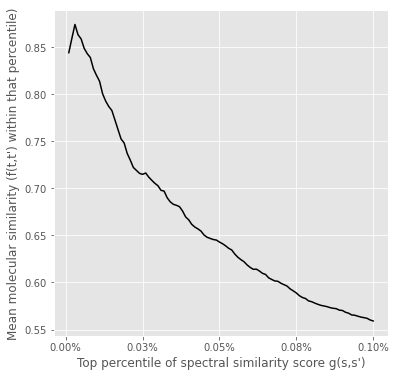

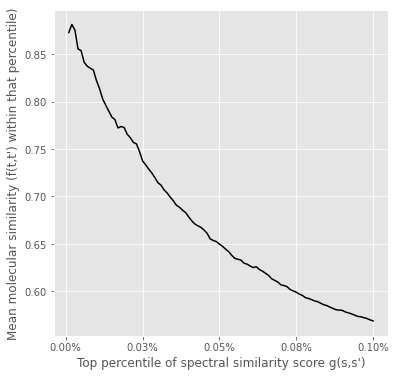

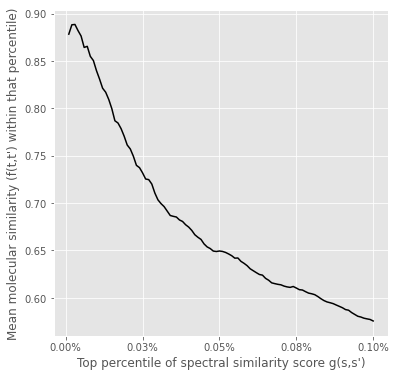

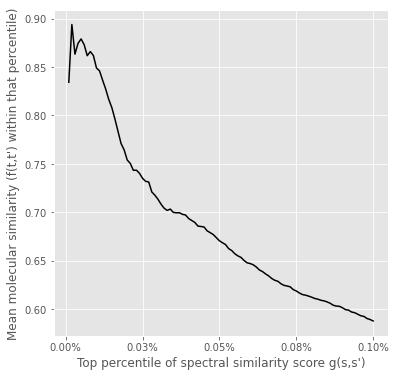

In [55]:
nums_to_keep = [400, 500, 1000, 1500]
percentiles_keep = []

for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Compute percentiles (trained on {num_keep} of {len(documents)} spectra).")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI2000_{num_keep}kept_201210.npy")
    matrix_similarities_spec2vec = np.load(file_matrix)
    percentile = plot_precentile(matrix_similarities_fingerprint_daylight[np.ix_(selected_idx[:n_subset],
                                                                                 selected_idx[:n_subset])],
                               matrix_similarities_spec2vec,
                               num_bins=100, show_top_percentile=0.1,
                               ignore_diagonal=True)
    percentiles_keep.append(percentile)

In [73]:
import gensim 
nums_to_keep = [500, 1000, 1500, 2500]
n_subset = 5000

for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Keep {num_keep} of {n_subset} spectra.")
    file_model = os.path.join(path_models, f"spec2vec_UI2000_{num_keep}kept_201210_iter_25.model")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI5000_{num_keep}kept_201210_iter_25.npy")
    # Load pretrained model
    model = gensim.models.Word2Vec.load(file_model)
    print(f"Model contains {len(model.wv.vocab)} words in the vocabulary.")
    
    # Score calculation
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0)
    tstart_sim = time.time()
    similarity_matrix = spec2vec_similarity.matrix([documents[i] for i in selected_idx[:n_subset]],
                                                   [documents[i] for i in selected_idx[:n_subset]],
                                                   is_symmetric=True)
    t_sim = time.time() - tstart_sim                           
    
    print(f"Similarity calculation time: {t_sim:.2f} s")
    np.save(file_matrix, similarity_matrix)

----------------------------------------
Keep 500 of 5000 spectra.
Model contains 32348 words in the vocabulary.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.49%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.62%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.92%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.25%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.32%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.44%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 83.13%.
Found 18 word(s) m

Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.94%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.07%.
Found 403 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.32%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.83%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.95%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.13%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.91%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.12%.
Found 81 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.39%.
Found 31 word(s) missin

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.13%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.28%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.86%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.39%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.66%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.98%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.09%.
Found 41 word(s) missing in 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.32%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.04%.
Found 152 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.75%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.25%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.00%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.49%.
Found 85 word(s) missi

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.56%.
Found 115 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.33%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.03%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.04%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.07%.
Found 91 word(s) missing in 

Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.63%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.05%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.15%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.18%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.43%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.31%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.16%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 25 word(s) missin

Found 417 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.66%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.48%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.94%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.50%.
Found 137 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.40%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.16%.
Found 101 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.50%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.03%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.95%.
Found 2 word(s) mis

Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.43%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.05%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.98%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.75%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.83%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.68%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.64%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 87 word(s) missing 

Found 222 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.82%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.82%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.05%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.54%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.70%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.90%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.19%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.96%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.51%.
Found 2 word(s) missi

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 139 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.14%.
Found 104 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.55%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.86%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.36%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.00%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.57%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.78%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.76%.
Found 37 word(s) mi

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.01%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.64%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.69%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.28%.
Found 267 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.26%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.67%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.39%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.08%.
Found 11 word(s) missin

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.44%.
Found 119 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.19%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.48%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.99%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.86%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.82%.
Found 62 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.65%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.94%.
Found 97 word(s) m

Found 497 word(s) missing in the model. Weighted missing percentage not covered by the given model is 73.67%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.46%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.93%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 51.56%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.71%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.12%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 57.15%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 84.83%.
Found 33 word(s) miss

Found 131 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.28%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.71%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.20%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.13%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.06%.
Found 27 word(s) missing in th

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.70%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.50%.
Found 136 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.21%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.59%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.94%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.12%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.32%.
Found 33 word(s) missing 

Found 182 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.23%.
Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.66%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.92%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.38%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 70.70%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.85%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.74%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.48%.
Found 74 word(s) mis

Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.42%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.24%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.36%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.26%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.20%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.57%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.60%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.19%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.20%.
Found 11 word(s) missing

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.57%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.50%.
Found 162 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.19%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.50%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.91%.
Found 29 word(s) missin

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.59%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.59%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.93%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.73%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.05%.
Found 34 word(s) missing in

Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.30%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.70%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.36%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.78%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.61%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.06%.
Found 62 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.80%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.95%.
Found 5 word(s) missi

Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.92%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.94%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.08%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.42%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.53%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.30%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.80%.
Found 89 word(s) missing 

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.86%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.65%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.75%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.09%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.51%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.23%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 75 word(s) missing i

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.94%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.10%.
Found 153 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.03%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.54%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.27%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.62%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.07%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 40 word(s) missing

Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.50%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.56%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.28%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.97%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.10%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.97%.
Found 119 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.59%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.62%.
Found 3 word(s) missi

Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.63%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.80%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.59%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.40%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.53%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.36%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.61%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.39%.
Found 38 word(s) missi

Found 72 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.99%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 60.90%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.90%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.36%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.49%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.99%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 84.24%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.87%.
Found 1 word(s) missing

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.65%.
Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.14%.
Found 126 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.00%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.26%.
Found 137 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.95%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.14%.
Found 7 word(s) missing in

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.23%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.02%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.80%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.88%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.28%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.86%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 79 word(s) missing in t

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.79%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.65%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.52%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.41%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.90%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.09%.
Found 2 word(s) missing in th

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.88%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.72%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.61%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.85%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.76%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 81 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.03%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.57%.
Found 44 word(s) missing i

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.64%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.36%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.57%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.64%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.56%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.67%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.85%.
Found 91 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.62%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 60 word(s) missing in 

Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.41%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.24%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.64%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.09%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.41%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.64%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.64%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.57%.
Found 2 word(s) missing

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.47%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 72.62%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.59%.
Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.32%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 88.04%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.88%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.29%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.98%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.33%.
Found 75 word(s) missin

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.17%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.57%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.80%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.59%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.
Found 49 word(s) missing in the m

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.49%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.62%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.92%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.25%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.32%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.44%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 83.13%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.16%.
Found 33 word(s) missi

Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.38%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 94.30%.
Found 158 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.13%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.01%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.58%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.13%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.88%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.26%.
Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.72%.
Found 109 word(s) miss

Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.17%.
Found 133 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.67%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.60%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.24%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.05%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.13%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.28%.
Found 10 word(s) missing 

Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.68%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.18%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.08%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.38%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.17%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 16 word(s) missing in

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.04%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.07%.
Found 91 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.71%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.07%.
Found 240 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.75%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.47%.
Found 154 word(s) missing in

Found 110 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.98%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.79%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.81%.
Found 118 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.01%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.12%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.37%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.29%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.47%.
Found 15 word(s) missing

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.45%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.18%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.39%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.81%.
Found 386 word(s) missing in th

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.62%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 270 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.21%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.68%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.03%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.33%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.37%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 12 word(s) missing

Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.33%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.66%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.68%.
Found 115 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.70%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 54.83%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.04%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.00%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.15%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.52%.
Found 45 word(s) mis

Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.91%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.74%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.39%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.67%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.61%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.54%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 16 word(s) missing i

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.02%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.77%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.47%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.22%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.83%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.27%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.74%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.98%.
Found 2 word(s) missing i

Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.56%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.94%.
Found 99 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.20%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.67%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 51.16%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.20%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.38%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.28%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.89%.
Found 79 word(s) missi

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.32%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.57%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.64%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 135 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.00%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 3 word(s) missing in 

Found 92 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.90%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.68%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.63%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.02%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 93.75%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.36%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.62%.
Found 13 word(s) missing in th

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.19%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.27%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.80%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.70%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.67%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.72%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 87 word(s) missing i

Found 347 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.74%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.89%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 62.71%.
Found 276 word(s) missing in the model. Weighted missing percentage not covered by the given model is 75.68%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.22%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.84%.
Found 72 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.30%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.89%.
Found 391 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.87%.
Found 31 word(s)

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.42%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 71.09%.
Found 108 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.59%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.73%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.14%.
Found 97 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.95%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 93.83%.
Found 78 word(s) missin

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.18%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.83%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.08%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.10%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.73%.
Found 116 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.62%.
Found 212 word(s) missing in the model. Weighted missing percentage not covered by the given model is 68.99%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.63%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.96%.
Found 11 word(s) missing

Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.37%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.89%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 175 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.66%.
Found 234 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.56%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.19%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.42%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 7 word(s) missing

Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.17%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.03%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.87%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.97%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.05%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.05%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.16%.
Found 418 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.27%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.01%.
Found 2 word(s) missin

Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.53%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.44%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.58%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.96%.
Found 72 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.84%.
Found 144 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.53%.
Found 412 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.60%.
Found 17 word(s) miss

Found 111 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.95%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.36%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.16%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.24%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.69%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.06%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 19 word(s) missing

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.29%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.33%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.66%.
Found 236 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.17%.
Found 414 word(s) missing in the model. Weighted missing percentage not covered by the given model is 69.24%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.16%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.59%.
Found 21 word(s) missing

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.53%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.99%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.74%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.46%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.32%.
Found 58 word(s) missing in t

Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.68%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.55%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.33%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.58%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.75%.
Found 506 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.21%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.54%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.98%.
Found 8 word(s) missin

Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.47%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.56%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.65%.
Found 210 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.85%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.87%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.25%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.28%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.30%.
Found 13 word(s) missi

Found 90 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.15%.
Found 318 word(s) missing in the model. Weighted missing percentage not covered by the given model is 69.08%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.03%.
Found 374 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.76%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.38%.
Found 138 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.82%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.56%.
Found 104 word(s) missing in the model. Weighted missing percentage not covered by the given model is 60.93%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.49%.
Found 6 word(s) mi

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.38%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.02%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.96%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.91%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.21%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.60%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.04%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.84%.
Found 660 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.23%.
Found 17 word(s) mis

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.17%.
Found 96 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.31%.
Found 131 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.60%.
Found 127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 57.81%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.19%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.81%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.02%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.74%.
Found 126 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.36%.
Found 50 word(s) 

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.66%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.28%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.93%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.44%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.67%.
Found 88 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.62%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.65%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.79%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.92%.
Found 55 word(s) missing in 

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.50%.
Found 145 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.25%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.68%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.64%.
Found 71 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.21%.
Found 355 word(s) missing in the model. Weighted missing percentage not covered by the given model is 55.99%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.44%.
Found 4 word(s) missi

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.91%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.95%.
Found 108 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.27%.
Found 193 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.42%.
Found 93 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.38%.
Found 227 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.36%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.94%.
Found 83 word(s) miss

Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.59%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.23%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.01%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.21%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.00%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.35%.
Found 27 word(s) missing i

Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.25%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.88%.
Found 71 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.59%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.40%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.65%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.02%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 49 word(s) missing i

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.16%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.31%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 78.84%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.47%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.52%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.88%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.01%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.02%.
Found 108 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.67%.
Found 186 word(s) miss

Found 145 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.75%.
Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.37%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.80%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.82%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.65%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.08%.
Found 5 word(s) missing i

Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.27%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.72%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.15%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.53%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.34%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.45%.
Found 3 word(s) missing in

Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.21%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.72%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.59%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.19%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.91%.
Found 58 word(s) missing in the m

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.47%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.99%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.54%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.32%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.61%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.50%.
Found 25 word(s) missing in t

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.06%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 196 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.88%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.51%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.27%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.42%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.16%.
Found 5 word(s) missing 

Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.76%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.64%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.81%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.33%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.51%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.39%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.91%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.48%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.64%.
Found 5 word(s) missing i

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.79%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.15%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.86%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.98%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.90%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.06%.
Found 116 word(s) missing in 

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.44%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.58%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.20%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.77%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 4 word(s) missing in th

Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.21%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.86%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.58%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.23%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.04%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.59%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.87%.
Found 31 word(s) missing 

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.00%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.00%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.85%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.31%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.52%.
Found 148 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.67%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.09%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.84%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.66%.
Found 19 word(s) missing

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.99%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.15%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.09%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.10%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.27%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.86%.
Found 99 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.06%.
Found 14 word(s) missing i

Found 162 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.31%.
Found 107 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.06%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.81%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.47%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.62%.
Found 1 word(s) missing in t

Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.23%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.00%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.78%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.94%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.09%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 20 word(s) missing in the

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 132 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.70%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.46%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.58%.
Found 4 word(s) missing in t

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.46%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 278 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.12%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.43%.
Found 48 word(s) missing in

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.19%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.58%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.31%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.57%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.29%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.11%.
Found 89 word(s) missing in

Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 96.58%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.16%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.72%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.91%.
Found 124 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.39%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.28%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.47%.
Found 189 word(s) missi

Found 180 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.65%.
Found 336 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.16%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.66%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.11%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.96%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.45%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.48%.
Found 27 word(s) missing 

Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.52%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.36%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.90%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.20%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.22%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.03%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.17%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.79%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.59%.
Found 10 word(s) missing in

Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.89%.
Found 183 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.19%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.49%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.72%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.28%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.04%.
Found 25 word(s) missing 

Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.78%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.86%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.60%.
Found 120 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.02%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 259 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.04%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.22%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 233 word(s) missing in the model. Weighted missing percentage not covered by the given model is 61.43%.
Found 3 word(s) missing

Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.72%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.52%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.27%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.46%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.77%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.13%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 5 word(s) missing in the

Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.89%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.59%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.84%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.27%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.62%.
Found 1 word(s) missing in the

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.09%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.44%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.42%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.23%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.21%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.44%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.46%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.95%.
Found 38 word(s) missing 

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.30%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.28%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.14%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.27%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.21%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.03%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.85%.
Found 3 word(s) missing in th

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.81%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.55%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.15%.
Found 100 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.86%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.50%.
Found 67 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.90%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.80%.
Found 18 word(s) missing in

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.71%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.60%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.51%.
Found 25 word(s) missing i

Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.54%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.93%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.84%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.94%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.14%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.87%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.97%.
Found 151 word(s) missing in the model. Weighted missing percentage not covered by the given model is 51.13%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.20%.
Found 17 word(s) missing

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.59%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.02%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.87%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 67.87%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.51%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.16%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.82%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.39%.
Found 31 word(s) missing in

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.11%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.28%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 90 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.68%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.67%.
Found 30 word(s) missing in t

Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.98%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.12%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.11%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.20%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.44%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.38%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.95%.
Found 35 word(s) missing in

Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.45%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.76%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.62%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.15%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.96%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.92%.
Found 82 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.03%.
Found 4 word(s) missing in

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.01%.
Found 180 word(s) missing in the model. Weighted missing percentage not covered by the given model is 57.90%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.08%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.09%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.33%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.02%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.13%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 7 word(s) missing 

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.58%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.05%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.42%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.28%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.43%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.47%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 35 word(s) missing in th

Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.15%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.47%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.13%.
Found 89 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.18%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.15%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.32%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.
Found 86 word(s) missing i

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.17%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.77%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.42%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.87%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.33%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.56%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.43%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.88%.
Found 26 word(s) missing 

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.60%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.43%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.63%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.59%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.15%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.06%.
Found 4 word(s) missing in t

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.10%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.89%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.90%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.46%.
Found 52 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.27%.
Found 48 word(s) missing in 

Found 145 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.94%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.92%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.32%.
Found 137 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.85%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.38%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.86%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.57%.
Found 49 word(s) missing 

Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.25%.
Found 162 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.31%.
Found 107 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.06%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.81%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.47%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 15 word(s) missing in

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.06%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 171 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.55%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.96%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.62%.
Found 11 word(s) missing in t

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.46%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.58%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.10%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.76%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 117 word(s) missing in

Found 278 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.12%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.43%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.43%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.14%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.54%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.10%.
Found 9 word(s) missing in

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.97%.
Found 105 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.81%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.28%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.03%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.88%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.35%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.29%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.48%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.66%.
Found 15 word(s) missin

Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.19%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 96.58%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.16%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.72%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.91%.
Found 124 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.39%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 66.28%.
Found 16 word(s) missi

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.48%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.88%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.96%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.19%.
Found 100 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.72%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 20 word(s) missing in t

Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.26%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.27%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.67%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.77%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.42%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.71%.
Found 26 word(s) missing in th

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.26%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.66%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.34%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.80%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.90%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.04%.
Found 77 word(s) missing in th

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.01%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.58%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.05%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.04%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.42%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.96%.
Found 45 word(s) missing in

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.19%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.50%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.91%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.19%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.53%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.39%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.20%.
Found 7 word(s) missing in the 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.45%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.90%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.60%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.78%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.69%.
Found 96 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.28%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.29%.
Found 42 word(s) missing in

Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.82%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.69%.
Found 198 word(s) missing in the model. Weighted missing percentage not covered by the given model is 42.86%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.22%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.90%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.73%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.61%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 1 word(s) missing

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.81%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.74%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.31%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.06%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.25%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.81%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.68%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 67.57%.
Found 11 word(s) miss

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.20%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.65%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.39%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.71%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.60%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.03%.
Found 1 word(s) missing in

Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.81%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.43%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.54%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.75%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.02%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 71 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.09%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.28%.
Found 25 word(s) missing in t

Found 50 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.49%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.51%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.55%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.04%.
Found 85 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.99%.
Found 9 word(s) missing in

Similarity calculation time: 24.33 s
----------------------------------------
Keep 1500 of 5000 spectra.
Model contains 59694 words in the vocabulary.
Found 179 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.37%.
Found 98 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.06%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.04%.
Found 96 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.43%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given m

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.20%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.29%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.59%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.07%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.10%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.75%.
Found 2 word(s) missing in th

Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.04%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.91%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 177 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.72%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.94%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.52%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.44%.
Found 17 word(s) missing in

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.23%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.92%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.62%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.38%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.68%.
Found 102 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.19%.
Found 25 word(s) missing in 

Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.66%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.87%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.48%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.35%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.07%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.91%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.56%.
Found 7 word(s) missing in

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.55%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.94%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.05%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.40%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.96%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.12%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.82%.
Found 1 word(s) missing in th

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.46%.
Found 223 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.21%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.42%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.20%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.03%.
Found 127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.05%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.10%.
Found 19 word(s) missing

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.71%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.56%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.60%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.97%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.85%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.71%.
Found 48 word(s) missing i

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.59%.
Found 105 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.83%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.04%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.34%.
Found 101 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.33%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.04%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.93%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 35 word(s) missing i

Found 216 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.64%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.41%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.04%.
Found 74 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.38%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 176 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.71%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 50 word(s) missing i

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.97%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.04%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.83%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 61.54%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.76%.
Found 3 word(s) missing in t

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.25%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.14%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.82%.
Found 1 word(s) missing in the mo

Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.18%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.64%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.04%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.49%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.67%.
Found 53 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.31%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.63%.
Found 91 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.90%.
Found 3 word(s) missing 

Found 58 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.46%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.71%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.79%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.00%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 48 word(s) missing in the 

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.97%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.17%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.65%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.87%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.38%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.36%.
Found 29 word(s) missing in 

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.39%.
Found 131 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.46%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.80%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.97%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 34.06%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.82%.
Found 35 word(s) missing in th

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.84%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.65%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.79%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.92%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 11 word(s) missing in the m

Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 62.45%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.02%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.96%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.87%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.10%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.65%.
Found 49 word(s) missing in the

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.51%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.13%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.92%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.37%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 4 word(s) missing in the mod

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.44%.
Found 104 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.31%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.31%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.94%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.78%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.65%.
Found 144 word(s) missing in

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.45%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.88%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.60%.
Found 100 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.37%.
Found 216 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.78%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 212 word(s) missing in the model. Weighted missing percentage not covered by the given model is 55.92%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 1 word(s) missing in

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.76%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.27%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.60%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.63%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 6 word(s) missing in the mo

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.51%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.63%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 143 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.71%.
Found 251 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.66%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.13%.
Found 1 word(s) missing in t

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.85%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.01%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.34%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.13%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 3 word(s) missing in the mod

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.59%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.16%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.01%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.45%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.08%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.71%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.09%.
Found 26 word(s) missing in t

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.09%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.64%.
Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.97%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.41%.
Found 45 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.97%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.46%.
Found 8 word(s) missing in t

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.01%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.64%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.45%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.27%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 2 word(s) missing in the 

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.55%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.17%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.84%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.62%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.26%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 3 word(s) missing in the mo

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.33%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.07%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.11%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.96%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.98%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.38%.
Found 36 word(s) missing in the 

Found 179 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.37%.
Found 98 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.06%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.04%.
Found 96 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.94%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.43%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 16 word(s) missing in t

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.75%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 48 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.04%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.46%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.26%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.13%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.69%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.63%.
Found 78 word(s) missing 

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.05%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.32%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 61.57%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.92%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.01%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.95%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.00%.
Found 27 word(s) missing in the

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.12%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.62%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.26%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.95%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.37%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.79%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.62%.
Found 1 word(s) missing in the

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.68%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.81%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.58%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.08%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.09%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.31%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.72%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.69%.
Found 9 word(s) missing in the

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.73%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.60%.
Found 126 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.61%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.15%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.84%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.61%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.89%.
Found 10 word(s) missing 

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.39%.
Found 84 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.29%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.57%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.80%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 42 word(s) missing in 

Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.61%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.71%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.09%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.00%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.73%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.15%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.68%.
Found 8 word(s) missing i

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.10%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.27%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.83%.
Found 66 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.60%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.74%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.25%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.61%.
Found 5 word(s) missing in

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 208 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.23%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.85%.
Found 566 word(s) missing in the model. Weighted missing percentage not covered by the given model is 45.95%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.
Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.23%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.64%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.86%.
Found 14 word(s) missin

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 44 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.33%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.47%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.80%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.96%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.58%.
Found 3 word(s) missing in th

Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.68%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.01%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.86%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.68%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.77%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.58%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.49%.
Found 9 word(s) missing in th

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.08%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.64%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.76%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.86%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.34%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.50%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 39.40%.
Found 14 word(s) missing in 

Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 62.45%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.02%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.96%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.87%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.10%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.65%.
Found 49 word(s) missing in the

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.90%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.74%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.25%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.54%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.68%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.50%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.93%.
Found 27 word(s) missing in the 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.21%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.45%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.54%.
Found 298 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.84%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.08%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.29%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.29%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.85%.
Found 9 word(s) missing in th

Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.30%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.82%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.90%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.99%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.83%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.04%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 8 word(s) missing in t

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.35%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.39%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.84%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.77%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.50%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 28 word(s) missing in the

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.41%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.87%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 78 word(s) missing in the mo

Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.28%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 219 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.09%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.66%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.00%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.05%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.66%.
Found 16 word(s) missing in t

Found 46 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.00%.
Found 127 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.71%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.00%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.74%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.57%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.09%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.64%.
Found 65 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.97%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 13 word(s) missing i

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.75%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.01%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.32%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.68%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.38%.
Found 110 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.09%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.48%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 54 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 20 word(s) missing in 

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.23%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.34%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.94%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.55%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.17%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.84%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.72%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.62%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.62%.
Found 29 word(s) missing in the

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 54 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.24%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.96%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 81 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.93%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.24%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 6 word(s) missing in the m

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.41%.
Found 131 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.81%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.22%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.20%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.54%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.42%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.65%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.75%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.06%.
Found 16 word(s) missing

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.71%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.82%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.43%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.48%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.48%.
Found 3 word(s) missing in the mod

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.07%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.76%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.97%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.73%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.89%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.32%.
Found 7 word(s) missing in the

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.81%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.22%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.61%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.31%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.25%.
Found 18 word(s) missing in the m

Found 136 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.01%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.84%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.07%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.59%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.14%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.09%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.21%.
Found 9 word(s) missing in the 

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.81%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.79%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 109 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.30%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.32%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.36%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.90%.
Found 4 word(s) missing in 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.50%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.15%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.83%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.59%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.44%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.24%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.53%.
Found 7 word(s) missing in the m

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.52%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.59%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.21%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.73%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.29%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.57%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 5 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.41%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.23%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.17%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.20%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.23%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.42%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 7 word(s) missing in the mode

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.28%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.04%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.49%.
Found 26 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.10%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.88%.
Found 36 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.48%.
Found 7 word(s) missing in the

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.48%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.00%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.47%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.81%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.59%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.32%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 57 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.12%.
Found 10 word(s) missing in the 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.27%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.58%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.28%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.44%.
Found 1 word(s) missing in the mode

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.04%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.36%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.27%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.17%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.99%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.66%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.51%.
Found 19 word(s) missing in the 

Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.72%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.30%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.80%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.87%.
Found 175 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.46%.
Found 9 word(s) missing in th

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.83%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.47%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.76%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.85%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.97%.
Found 144 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.38%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.35%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 22 word(s) missing in 

Found 247 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.52%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.82%.
Found 142 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.17%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.87%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.26%.
Found 63 word(s) missing

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.31%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.53%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.15%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.91%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.32%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.66%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.56%.
Found 9 word(s) missing in the model

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.05%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.16%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.92%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.93%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.03%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.86%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.05%.
Found 3 word(s) missing in th

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.18%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.57%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.03%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.64%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.02%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.52%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.88%.
Found 2 word(s) missing in the mod

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.99%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.77%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.18%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.08%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.44%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.13%.
Found 1 word(s) missing in the mod

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.23%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.54%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.22%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.74%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.60%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.21%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.05%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.78%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.20%.
Found 20 word(s) missing in th

Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.26%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 35.87%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.93%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.67%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.86%.
Found 7 word(s) missing in the m

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.59%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.05%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.81%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.11%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.93%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.01%.
Found 158 word(s) missing in the model. Weighted missing percentage not covered by the given model is 23.05%.
Found 6 word(s) missing i

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.70%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.75%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.71%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.36%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.87%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.70%.
Found 1 word(s) missing in the mo

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.63%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.56%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.45%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.18%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.06%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.40%.
Found 5 word(s) missing in the mo

Found 73 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.30%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.26%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.58%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.52%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 72 word(s) missing in the mo

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.58%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.23%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.16%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.11%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 5 word(s) missing in the mod

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.18%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.31%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.66%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.59%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.57%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.08%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.45%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.70%.
Found 40 word(s) missing in the m

Found 64 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.19%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.17%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.64%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.46%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.38%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.48%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.21%.
Found 9 word(s) missing in the mod

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.15%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.09%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.25%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.05%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.50%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.89%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.41%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 8 word(s) missing in the mode

Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.46%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.11%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.43%.
Found 18 word(s) missing in the m

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.07%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 47.53%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.84%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.51%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.82%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.87%.
Found 1 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.72%.
Found 95 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.97%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.48%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.86%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.69%.
Found 166 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.17%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 6 word(s) missing in the 

Found 247 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.08%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.52%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.82%.
Found 142 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.17%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.85%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.87%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.26%.
Found 63 word(s) missing

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.90%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.29%.
Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.81%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.91%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.00%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.10%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 52.32%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.52%.
Found 4 word(s) missing in the

Similarity calculation time: 23.72 s


----------------------------------------
Compute percentiles (trained on 500 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1000 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1500 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 2500 of 12797 spectra).


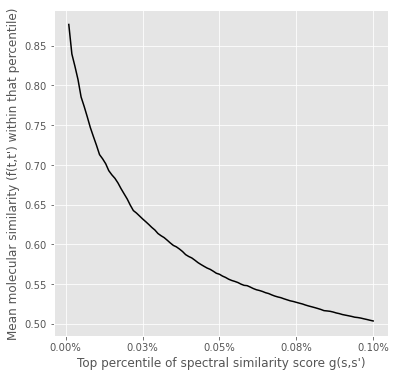

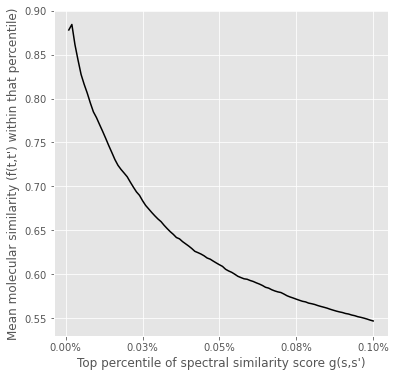

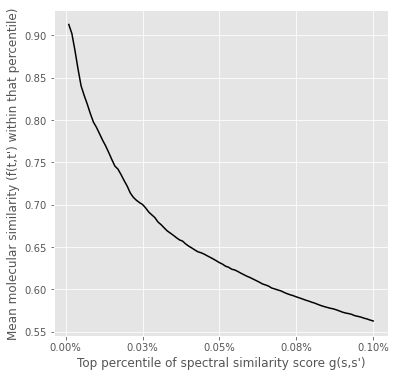

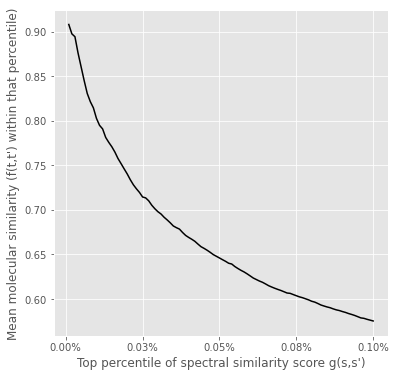

In [74]:
nums_to_keep = [500, 1000, 1500, 2500]
percentiles_keep_iter_25 = []

n_subset = 5000
for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Compute percentiles (trained on {num_keep} of {len(documents)} spectra).")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI5000_{num_keep}kept_201210_iter_25.npy")
    matrix_similarities_spec2vec = np.load(file_matrix)
    percentile = plot_precentile(matrix_similarities_fingerprint_daylight[np.ix_(selected_idx[:n_subset],
                                                                                 selected_idx[:n_subset])],
                               matrix_similarities_spec2vec,
                               num_bins=100, show_top_percentile=0.1,
                               ignore_diagonal=True)
    percentiles_keep_iter_25.append(percentile)

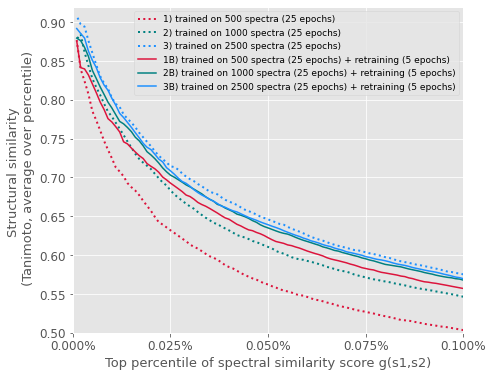

In [129]:
from matplotlib import pyplot as plt

colors = ["crimson", "teal", "dodgerblue", "orange"]
#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, count in enumerate([0,1,3]):
    plt.plot(x_percentiles, percentiles_keep_iter_25[count], ":", linewidth=2,
             color=colors[i],#(i/color_max, 0.1, 1-i/color_max, 0.4+0.5*i/color_max),
             label=f'{i+1}) trained on {nums_to_keep[count]} spectra (25 epochs)')
    color_count += 1

for i, count in enumerate([0,1,3]):
    plt.plot(x_percentiles, percentiles_keep[count], 
             color=colors[i],#(i/color_max, 0.1, 1-i/color_max, 0.4+0.5*i/color_max),
             label=f'{i+1}B) trained on {nums_to_keep[count]} spectra (25 epochs) + retraining (5 epochs)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=9)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Structural similarity \n (Tanimoto, average over percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.5, 0.92)
plt.savefig(os.path.join(path_data, 'explore_retraining.svg'))

(0.54, 0.92)

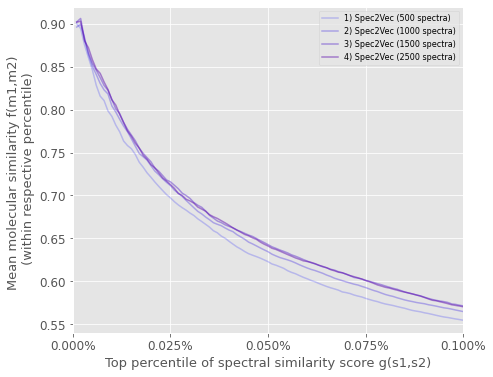

In [64]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles_keep):
    plt.plot(x_percentiles, percentiles_keep[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_keep[i]} spectra)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.54, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

# Add retraining step

In [70]:
import gensim
from spec2vec.utils import TrainingProgressLogger
nums_to_keep = [500, 1000, 1500, 2500]
n_subset = 5000
num_epochs = 5


for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Keep {num_keep} of {n_subset} spectra.")
    file_model = os.path.join(path_models, f"spec2vec_UI2000_{num_keep}kept_201210_iter_25.model")
    # Load pretrained model
    model = gensim.models.Word2Vec.load(file_model)
    print(f"Model contains {len(model.wv.vocab)} words in the vocabulary.")

    # Retrain model
    model.build_vocab([documents[i].words for i in selected_idx[num_keep:n_subset]], update=True)
    print(f"After retraining: Model contains {len(model.wv.vocab)} words in the vocabulary.")
    training_progress_logger = TrainingProgressLogger(num_epochs)
    model.train([documents[i].words for i in selected_idx[num_keep:n_subset]],
                total_examples=n_subset,
                callbacks = [training_progress_logger], epochs=num_epochs)
    
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI5000_{num_keep}kept_retrained_201210.npy")
    # Score calculation
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0)
    tstart_sim = time.time()
    similarity_matrix = spec2vec_similarity.matrix([documents[i] for i in selected_idx[:n_subset]],
                                                   [documents[i] for i in selected_idx[:n_subset]],
                                                   is_symmetric=True)
    t_sim = time.time() - tstart_sim                           
    
    print(f"Similarity calculation time: {t_sim:.2f} s")
    np.save(file_matrix, similarity_matrix)

----------------------------------------
Keep 500 of 5000 spectra.
Model contains 32348 words in the vocabulary.
After retraining: Model contains 91498 words in the vocabulary.
  Epoch 1 of 5.Change in loss after epoch 1: 0.0
  Epoch 2 of 5.Change in loss after epoch 2: 0.0
  Epoch 3 of 5.Change in loss after epoch 3: 0.0
  Epoch 4 of 5.Change in loss after epoch 4: 0.0
  Epoch 5 of 5.Change in loss after epoch 5: 0.0
Similarity calculation time: 15.41 s
----------------------------------------
Keep 1000 of 5000 spectra.
Model contains 48460 words in the vocabulary.
After retraining: Model contains 91498 words in the vocabulary.
  Epoch 1 of 5.Change in loss after epoch 1: 0.0
  Epoch 2 of 5.Change in loss after epoch 2: 0.0
  Epoch 3 of 5.Change in loss after epoch 3: 0.0
  Epoch 4 of 5.Change in loss after epoch 4: 0.0
  Epoch 5 of 5.Change in loss after epoch 5: 0.0
Similarity calculation time: 16.13 s
----------------------------------------
Keep 1500 of 5000 spectra.
Model contain

----------------------------------------
Compute percentiles (trained on 500 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1000 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 1500 of 12797 spectra).
----------------------------------------
Compute percentiles (trained on 2500 of 12797 spectra).


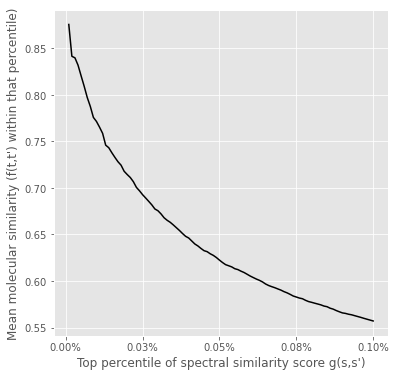

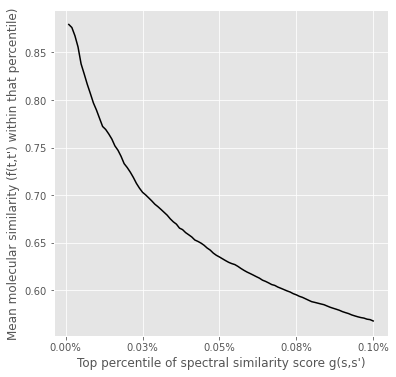

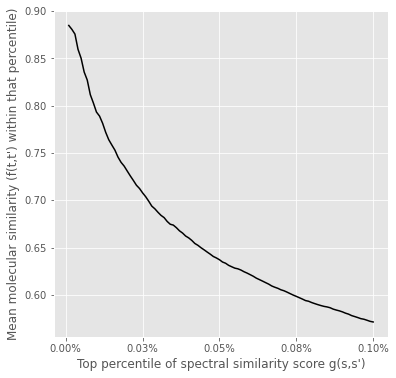

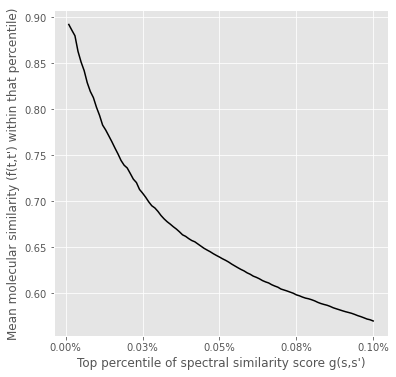

In [71]:
nums_to_keep = [500, 1000, 1500, 2500]
percentiles_keep = []

n_subset = 5000
for num_keep in nums_to_keep:
    print(20 * "--")
    print(f"Compute percentiles (trained on {num_keep} of {len(documents)} spectra).")
    file_matrix = os.path.join(path_data, f"similarities_spec2vec_UI5000_{num_keep}kept_retrained_201210.npy")
    matrix_similarities_spec2vec = np.load(file_matrix)
    percentile = plot_precentile(matrix_similarities_fingerprint_daylight[np.ix_(selected_idx[:n_subset],
                                                                                 selected_idx[:n_subset])],
                               matrix_similarities_spec2vec,
                               num_bins=100, show_top_percentile=0.1,
                               ignore_diagonal=True)
    percentiles_keep.append(percentile)

(0.4, 0.92)

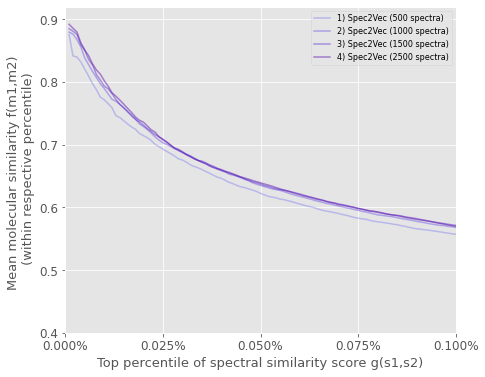

In [72]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles_keep):
    plt.plot(x_percentiles, percentiles_keep[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_keep[i]} spectra)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

(0.4, 0.92)

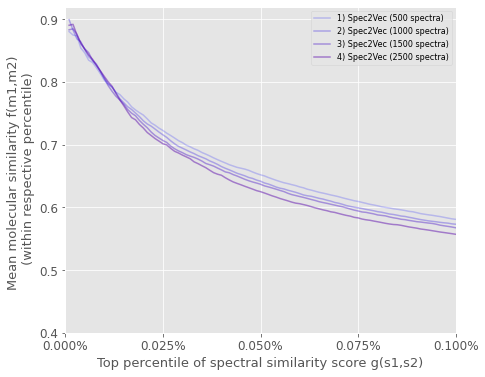

In [68]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles_keep):
    plt.plot(x_percentiles, percentiles_keep[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_keep[i]} spectra)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

(0.4, 0.92)

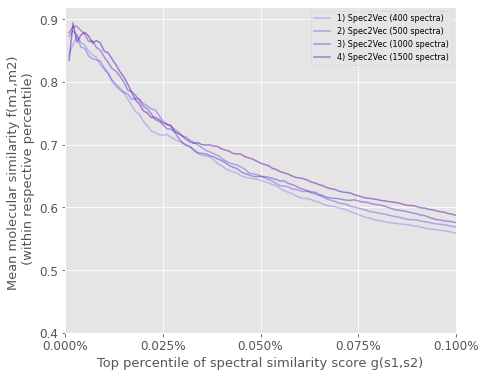

In [56]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles_keep):
    plt.plot(x_percentiles, percentiles_keep[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_keep[i]} spectra)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

(0.4, 0.92)

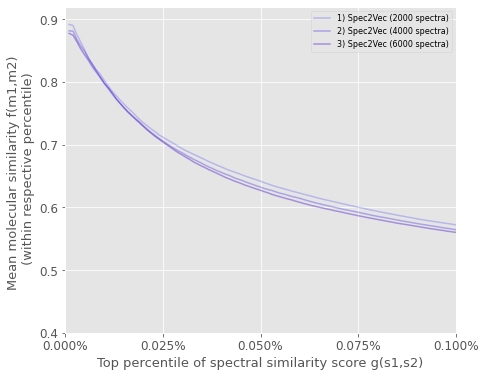

In [28]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]

color_count = 0
color_max = len(percentiles) + 1
for i, percentile in enumerate(percentiles_keep):
    plt.plot(x_percentiles, percentiles_keep[i], 
             color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
             label=f'{i+1}) Spec2Vec ({nums_to_keep[i]} spectra)')
    color_count += 1

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
#plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))